In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from collections import defaultdict
from datetime import datetime
from scipy.stats.stats import pearsonr

# Data Understanding

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)
df['BasketDay'] = df['BasketDate'].dt.day_name()

In [3]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                float64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
BasketDay                  object
dtype: object

# Data Quality 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
 8   BasketDay        471910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 36.0+ MB


In [5]:
# 13% of the records have CustomerID = null.

df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
BasketDay              0
dtype: int64

In [6]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


In [7]:
# Distinct BasketIDs.

len(df['BasketID'].unique())

24627

In [8]:
# Distinct known CustomerIDs - NaN.

len(df['CustomerID'].unique()) - 1

4372

In [9]:
# Only these two (aborted transactions).

df[df['Sale'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1,Friday
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1,Friday


In [10]:
# All these BaskedIDs have a leading 'C', that means "canceled order".

df[df['Qta'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1,Wednesday
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,Wednesday
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12,Wednesday
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,Wednesday
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,Wednesday
...,...,...,...,...,...,...,...,...,...
540449,C581490,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,Friday
541541,C581499,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,M,Manual,-1,Friday
541715,C581568,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5,Friday
541716,C581569,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,Friday


In [11]:
# Customers' nationalities.

countries_before = df['CustomerCountry'].value_counts()

(-12000.0, 39500.0)

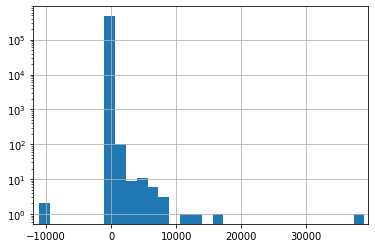

In [12]:
# Sales distribution.

ax = df.Sale.hist(log=True, bins=30)
ax.set_xlim((-12000, 39500))

(-82000.0, 82000.0)

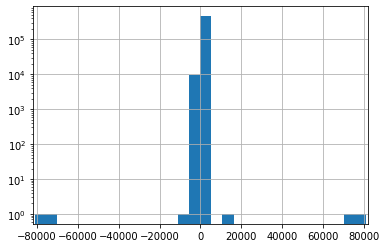

In [13]:
# Qta distribution.

ax = df.Qta.hist(log=True, bins=30)
ax.set_xlim((-82000, 82000))

<AxesSubplot:>

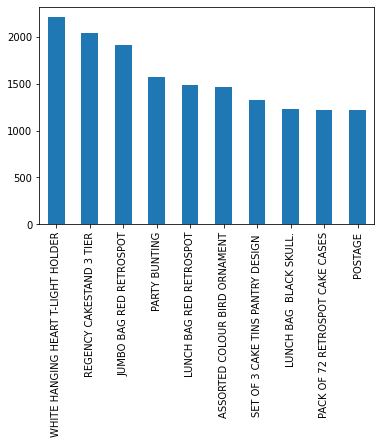

In [14]:
# Top-10 products.

df['ProdDescr'].value_counts().head(10).plot(kind='bar')

# Data Cleaning

In [15]:
# Remove the (2) rows with sale < 0.

df = df[~(df['Sale'] < 0)]

In [16]:
df.describe()

,Sale,CustomerID,Qta
count,471908.000000,406830.000000,471908.000000
mean,4.077844,15287.684160,10.716574
std,80.612300,1713.603074,231.355625
min,0.000000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


In [17]:
# Create a new field "Canceled".

canceled = "C"

df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))

df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)

df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])


# Now we can compute the total.

df['Total'] = df['Sale'] * df['Qta']

In [18]:
# Fix BasketID type (object -> int64)

df['BasketID'] = df['BasketID'].astype(int)
df.dtypes

BasketID                    int64
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                float64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
BasketDay                  object
Canceled                     bool
Total                     float64
dtype: object

In [19]:
# ProdDescr null ==> (CustomerID null AND Sale = 0).

#df[(df['ProdDescr'].isnull()) & ~((df['CustomerID'].isnull()) & (df['Sale'] == 0))]

In [20]:
# To find bad descriptions.

#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [21]:
# Load blacklisted descriptions.

with open('blacklist_prod_descr.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [22]:
# If len < 5 or > 6, probably not a valid product. We made another blacklist.

with open('blacklist_prod_id.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdID'].isin(blacklist)]

In [23]:
# ProdDescr null ==> Sale = 0

df = df[~(df['Sale'] == 0)]

In [24]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,468254.000000,468254.000000,404879.000000,468254.000000,468254.00000
mean,560237.415375,3.108487,15295.252992,12.028373,21.28773
std,13289.224748,4.461011,1710.399838,231.039082,393.34433
min,536365.000000,0.001000,12346.000000,1.000000,0.00100
25%,548497.000000,1.250000,13969.000000,2.000000,4.13000
50%,561087.000000,2.080000,15159.000000,4.000000,10.20000
75%,571931.000000,3.750000,16794.000000,12.000000,17.70000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.60000


In [25]:
# There are still too small values of Sale (less than 1 penny).

df[df['Sale'] < 0.01]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay,Canceled,Total
157195,550193,2011-04-15 09:27:00,0.001,13952.0,United Kingdom,PADS,PADS TO MATCH ALL CUSHIONS,1,Friday,False,0.001
279045,561226,2011-07-26 10:13:00,0.001,15618.0,United Kingdom,PADS,PADS TO MATCH ALL CUSHIONS,1,Tuesday,False,0.001
359871,568200,2011-09-25 14:58:00,0.001,16198.0,United Kingdom,PADS,PADS TO MATCH ALL CUSHIONS,1,Sunday,False,0.001


In [26]:
df = df[~(df['Sale'] < 0.01)]

In [27]:
# Distinct BasketIDs after cleaning (including 'Canceled').
# 5.27% of loss bad entries.

len(df['BasketID'].unique())

23061

In [28]:
# Distinct known CustomerIDs - NaN, after cleaning.

len(df['CustomerID'].unique()) - 1

4362

In [29]:
# Percentage for each country dropped.

countries_after = df['CustomerCountry'].value_counts()
dropped = (1 - countries_after.divide(countries_before)) * 100
dropped

Australia               0.397141
Austria                 3.491272
Bahrain                 0.000000
Belgium                 4.736588
Brazil                  0.000000
Canada                  0.662252
Channel Islands         0.659631
Cyprus                  0.482315
Czech Republic          6.666667
Denmark                 3.598972
EIRE                    1.495399
European Community      4.918033
Finland                 6.043165
France                  3.800587
Germany                 4.212744
Greece                  2.739726
Hong Kong               2.173913
Iceland                 0.000000
Israel                  0.000000
Italy                   2.490660
Japan                   0.837989
Lebanon                 0.000000
Lithuania               0.000000
Malta                   3.149606
Netherlands             1.897933
Norway                  2.486188
Poland                  1.466276
Portugal                2.943144
RSA                     1.724138
Saudi Arabia            0.000000
Singapore 

(0.0, 700.0)

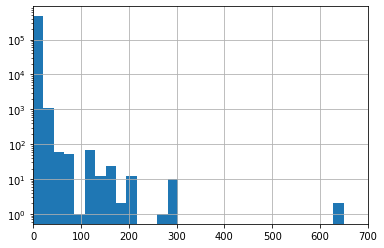

In [30]:
#gdf = df.groupby(['BasketID']).sum()

# Sales distribution after cleaning.

ax = df.Sale.hist(log=True, bins=30)
ax.set_xlim((0, 700))

(0.0, 82000.0)

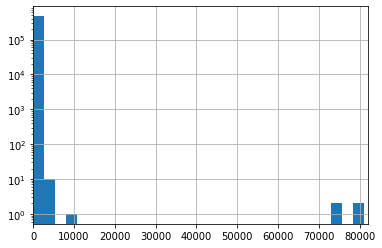

In [31]:
# Qta distribution after cleaning.

ax = df.Qta.hist(log=True, bins=30)
ax.set_xlim((0, 82000))

<AxesSubplot:>

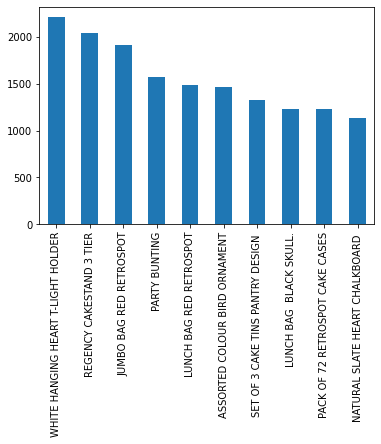

In [32]:
# Top-10 products.

df['ProdDescr'].value_counts().head(10).plot(kind='bar')

In [33]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,468251.000000,468251.000000,404876.000000,468251.000000,468251.000000
mean,560237.417710,3.108507,15295.253282,12.028444,21.287866
std,13289.254039,4.461019,1710.404209,231.039821,393.345586
min,536365.000000,0.030000,12346.000000,1.000000,0.060000
25%,548497.000000,1.250000,13969.000000,2.000000,4.130000
50%,561087.000000,2.080000,15159.000000,4.000000,10.200000
75%,571931.000000,3.750000,16794.000000,12.000000,17.700000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.600000


In [34]:
# The higher the quantity of the order, the higher the probability to be re-done and then canceled
# (first canceled or not?). The price drops and we cancel and reorder it (high quantity, expensive).
# That may identify a certain type of behavior.


'''df1 = df[(df['Qta'] > 1000) & (df['Qta'] < 90000) & (df['Canceled'])]
df2 = df[(df['Qta'] > 1000) & (df['Qta'] < 90000) & (~df['Canceled'])]
mergedStuff = pd.merge(df1, df2, on=['ProdID', 'CustomerID', 'Qta', 'ProdDescr'], how='inner')
mergedStuff'''

"df1 = df[(df['Qta'] > 1000) & (df['Qta'] < 90000) & (df['Canceled'])]\ndf2 = df[(df['Qta'] > 1000) & (df['Qta'] < 90000) & (~df['Canceled'])]\nmergedStuff = pd.merge(df1, df2, on=['ProdID', 'CustomerID', 'Qta', 'ProdDescr'], how='inner')\nmergedStuff"

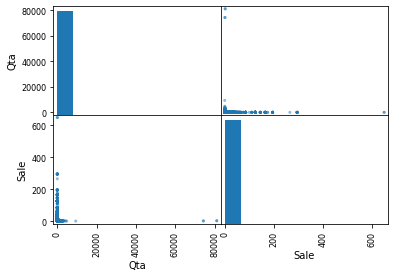

In [35]:
pd.plotting.scatter_matrix(df[['Qta', 'Sale']])
plt.show()

<AxesSubplot:>

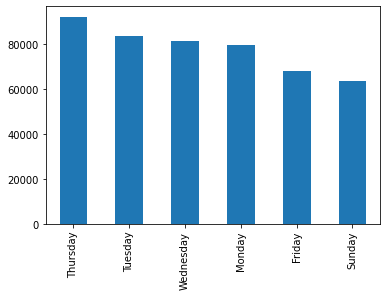

In [36]:
df['BasketDay'].value_counts().plot(kind='bar')

In [37]:
'''
DU
- Identify outliers

DP
- New features
- Indicators
- Analysis

Final
- Clustering
- K-means
'''

'\nDU\n- Identify outliers\n\nDP\n- New features\n- Indicators\n- Analysis\n\nFinal\n- Clustering\n- K-means\n'

In [38]:
'''
Sale ()
CustomerCountry
Qta
BasketDay (saturday is missing)
'''

'\nSale ()\nCustomerCountry\nQta\nBasketDay (saturday is missing)\n'

In [39]:
gdf = df.groupby(['BasketID']).sum()
gdf.drop(columns=['CustomerID', 'Sale'], inplace=True)
gdf

,Qta,Canceled,Total
BasketID,,,
536365,40,0,139.12
536366,12,0,22.20
536367,83,0,278.73
536368,15,0,70.05
536369,3,0,17.85
...,...,...,...
581583,76,0,124.60
581584,120,0,140.64
581585,278,0,329.05


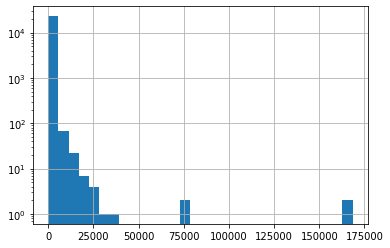

In [40]:
ax = gdf.Total.hist(log=True, bins=30)
#ax.set_xlim((0, 700))

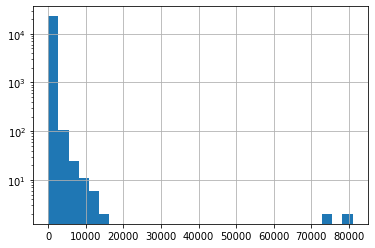

In [41]:
ax = gdf.Qta.hist(log=True, bins=30)
#ax.set_xlim((0, 700))

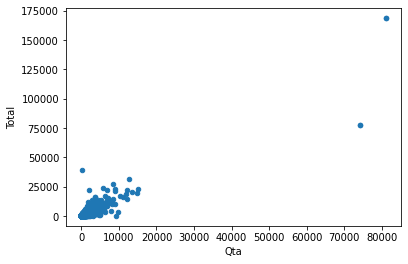

In [42]:
ax = gdf.plot.scatter(x='Qta', y='Total')